# Setting  a GP on H(z)
we are going to use data on H(z), dA(z); an integral of H(z) and f(z); the solution of a differential equation on H(z)

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
from scipy.integrate import quad
import pyccl as ccl
import arviz as az
import theano
import theano.tensor as tt
import os
import utils
%matplotlib inline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Make data

In [2]:
#####Forecast
dz = 0.1
z_arr = np.arange(0.15, 1.85+0.1, dz)
rels_dA  = [2.78, 1.87, 1.45, 1.19, 1.01, 0.87, 0.77, 
            0.76, 0.88, 0.91, 0.91, 0.91, 1.00, 1.17, 
            1.50, 2.36, 3.62, 4.79]
rels_H = [5.34, 3.51, 2.69, 2.20, 1.85, 1.60, 1.41, 
          1.35, 1.42, 1.41, 1.38, 1.36, 1.46, 1.66, 
          2.04, 3.15, 4.87, 6.55]
rels_fs = [5.34, 3.51, 2.69, 2.20, 1.85, 1.60, 1.41, 
           1.35, 1.42, 1.41, 1.38, 1.36, 1.46, 1.66, 
           2.04, 3.15, 4.87, 6.55]
############

#####Make data
dz_f = 0.01
z_arr_f = np.arange(0.0, 1.85+0.1, dz_f)
a_arr_f = 1/(1+z_arr_f) 
x_arr_f = np.log(a_arr_f)
idx = np.array([int(x) for x in z_arr/(dz_f)])

utils = utils.utils()
LCDM = utils.get_LCDM(z_arr_f)
Hkms_arr_f = LCDM['Hkms_arr']
H_arr_f = LCDM['H_arr']
dA_arr_f = LCDM['dA_arr']
f_arr_f = LCDM['f_arr']
s8_arr_f = LCDM['s8_arr']
fs_arr_f = f_arr_f*s8_arr_f

sig_H_arr = H_arr_f[idx]*rels_H/100
sig_dA_arr = dA_arr_f[idx]*rels_dA/100
sig_fs_arr = fs_arr_f[idx]*rels_fs/100

H_data = H_arr_f[idx] + np.random.randn(len(z_arr))*sig_H_arr
dA_data = dA_arr_f[idx] + np.random.randn(len(z_arr))*sig_dA_arr
fs_data = fs_arr_f[idx] + np.random.randn(len(z_arr))*sig_fs_arr

H_cov = np.zeros([len(z_arr), len(z_arr)])
dA_cov = np.zeros([len(z_arr), len(z_arr)])
fs_cov = np.zeros([len(z_arr), len(z_arr)])
for i in np.arange(len(z_arr)):
    H_cov[i,i] = sig_H_arr[i]**2
    dA_cov[i,i] = sig_dA_arr[i]**2
    fs_cov[i,i] = sig_fs_arr[i]**2

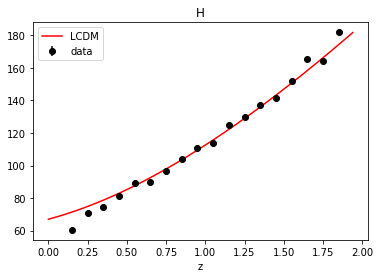

In [3]:
plt.plot(z_arr_f, Hkms_arr_f, "r-", label='LCDM')
plt.errorbar(z_arr, H_data*utils.c/1000, yerr = sig_H_arr, fmt='ko', label='data')

# axis labels and title
plt.xlabel("z")
plt.title("H")
plt.legend();

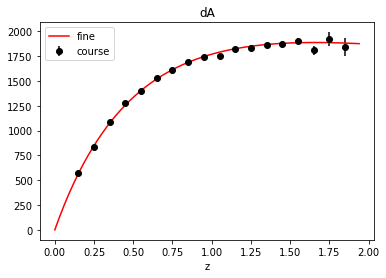

In [4]:
plt.plot(z_arr_f, dA_arr_f, "r-", label='fine')
plt.errorbar(z_arr, dA_data, yerr = sig_dA_arr, fmt='ko', label='course')

# axis labels and title
plt.xlabel("z")
plt.title("dA")
plt.legend();

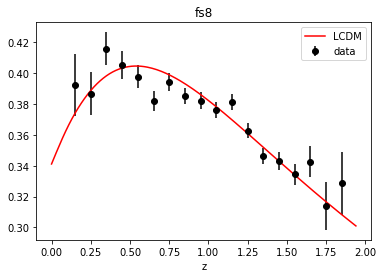

In [5]:
plt.plot(z_arr_f, fs_arr_f, "r-", label='LCDM')
plt.errorbar(z_arr, fs_data, yerr = sig_fs_arr, fmt='ko', label='data')

# axis labels and title
plt.xlabel("z")
plt.title("fs8")
plt.legend();

In [6]:
#n_start = 1000
n_tune = 10
n_finish = 10
#n_window = n_start * 2 ** np.arange(np.floor(np.log2((n_finish - n_tune) / n_start)))
#n_window = n_window.astype(int)

#path = 'DESIfs_{}_{}'.format(n_finish, n_tune)
#os.mkdir(path)

In [8]:
with pm.Model() as model:
    #Define parameters
    ℓ = pm.Uniform("ℓ", 0, 1) 
    η = pm.Uniform("η", 0, 8) 
    gp_cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ) + pm.gp.cov.WhiteNoise(1e-3)
    gp = pm.gp.Latent(cov_func=gp_cov)
    
    #Set fine GP
    #DHkms_gp_f = gp.prior("DHkms_gp_f", X=z_arr_f[:, None]) 
    #Hkms_gp_f = pm.Deterministic("Hkms_gp_f", tt.as_tensor_variable(DHkms_gp_f+Hkms_arr_f)) 
    #H_gp_f = pm.Deterministic("H_gp_f", tt.as_tensor_variable(Hkms_gp_f*1000/utils.c))
    #H0 = pm.Deterministic("H0", tt.as_tensor_variable(H_gp_f[0])) 
    
    #Set up GP
    DHkms_gp = gp.prior("DHkms_gp", X=z_arr[:, None]) 
    Hkms_gp = pm.Deterministic("Hkms_gp", tt.as_tensor_variable(DHkms_gp+Hkms_arr_f[idx])) 
    H_gp = pm.Deterministic("H_gp", tt.as_tensor_variable(Hkms_gp*1000/utils.c))     
    
    #Set fine GP
    DHkms_gp_f = gp.conditional("DHkms_gp_f", Xnew=z_arr_f[:, None]) 
    Hkms_gp_f = pm.Deterministic("Hkms_gp_f", tt.as_tensor_variable(DHkms_gp_f+Hkms_arr_f)) 
    H_gp_f = pm.Deterministic("H_gp_f", tt.as_tensor_variable(Hkms_gp_f*1000/utils.c))
    H0 = pm.Deterministic("H0", tt.as_tensor_variable(H_gp_f[0])) 
    
    #Numerical integration scheme
    dH_gp_f = pm.Deterministic("dH_gp_f", tt.as_tensor_variable(1/H_gp_f))
    dA_gp_f = tt.zeros(len(z_arr_f))
    dA_gp_f = tt.inc_subtensor(dA_gp_f[1:],
              tt.as_tensor_variable(dz_f*tt.cumsum(dH_gp_f)[:-1]/(1+z_arr_f)[1:]))
    dA_gp_f = pm.Deterministic('dA_gp_f', dA_gp_f)

    #Second order differentiation scheme
    Wm0 = pm.Uniform("Wm0", 0, 1) #0.3158 
    Wm =  pm.Deterministic("Wm", Wm0*(H0/H_gp_f)**2*(1+z_arr_f)**3)
    comf_H = pm.Deterministic("comf_H", a_arr_f*H_gp_f)
    diff_comf_H = tt.zeros(len(z_arr_f))
    diff_comf_H = tt.inc_subtensor(diff_comf_H[0], (comf_H[1]-comf_H[0])/(x_arr_f[1]-x_arr_f[0]))
    diff_comf_H = tt.inc_subtensor(diff_comf_H[1:-1], (comf_H[2:]-comf_H[:-2])/(x_arr_f[2:]-x_arr_f[:-2]))
    diff_comf_H = tt.inc_subtensor(diff_comf_H[-1], (comf_H[-1]-comf_H[-2])/(x_arr_f[-1]-x_arr_f[-2]))
    diff_comf_H  = pm.Deterministic("diff_comf_H", diff_comf_H)
    q = 1+(diff_comf_H/comf_H)
    
    #Implement second Order Runge-Kutta method
    f0 = 0.52763
    f_gp_f = tt.zeros(len(z_arr_f))
    f_gp_f = tt.inc_subtensor(f_gp_f[0], f0)
    for i in np.arange(1, len(z_arr_f)):
        k0 = (-1/(1+z_arr_f[i-1]))*((3/2)*Wm[i-1]-f_gp_f[i-1]**2-q[i-1]*f_gp_f[i-1])
        f1 = f_gp_f[i-1]+dz_f*k0
        k1 = (-1/(1+z_arr_f[i]))*((3/2)*Wm[i]-f1**2-q[i]*f1)
        f_gp_f = tt.inc_subtensor(f_gp_f[i], f_gp_f[i-1] + dz_f*(k1+k0)/2)
    f_gp_f = pm.Deterministic("f_gp_f", f_gp_f) 
    
    #Integrate for s8 method1
    #s80 = 0.811 #pm.Uniform("s80", 0.7, 1.1)
    #s8_gp_f = tt.ones(len(z_arr_f))
    #s8_gp_f = tt.inc_subtensor(s8_gp_f[1:], tt.exp(dz_f*tt.cumsum(-f_gp_f/(1+z_arr_f)))[:-1])
    #s8_gp_f = pm.Deterministic("s8_gp_f", s8_gp_f*s80) 
    
    #integrate for s8 method2
    s80 = pm.Uniform("s80", 0.7, 1.1)
    s8_gp_f = tt.zeros(len(z_arr_f))
    s8_gp_f = tt.inc_subtensor(s8_gp_f[0], s80)
    for i in np.arange(1, len(z_arr_f)):
        k0 = -1*(f_gp_f[i-1]*s8_gp_f[i-1])/(1+z_arr_f[i-1])
        s8_gp_f = tt.inc_subtensor(s8_gp_f[i], s8_gp_f[i-1] + dz_f*(k0))
    s8_gp_f = pm.Deterministic("s8_gp_f", s8_gp_f) 
    
    fs8_gp_f = f_gp_f*s8_gp_f
    fs8_gp_f = pm.Deterministic("fs8_gp_f", fs8_gp_f) 
    
    #Evaluate arrays at data points
    idx = np.array([int(x) for x in z_arr/dz_f])
    #H_gp = pm.Deterministic('H_gp', tt.as_tensor_variable(H_gp_f[idx]))
    dA_gp = pm.Deterministic('dA_gp', tt.as_tensor_variable(dA_gp_f[idx]))
    fs8_gp = pm.Deterministic('fs8_gp', tt.as_tensor_variable(fs8_gp_f[idx]))

    #Set up Gaussian likelihoods
    lkl = pm.MvNormal("H_obs", mu=H_gp, cov=H_cov, observed=H_data)
    lkl *= pm.MvNormal("dA_obs", mu=dA_gp, cov=dA_cov, observed=dA_data)
    lkl *= pm.MvNormal("fs8_obs", mu=fs8_gp, cov=fs_cov, observed=fs_data)

    trace = pm.sample(n_finish, return_inferencedata=True, tune=n_tune)

Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s80, Wm0, DHkms_gp_f, DHkms_gp_rotated_, η, ℓ]


Sampling 4 chains for 10 tune and 10 draw iterations (40 + 40 draws total) took 76 seconds.
/home/jaimerz/.local/lib/python3.8/site-packages/pymc3/sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 1.0705567501380596e-06, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The a

In [ ]:
fig = pm.traceplot(trace)

In [ ]:
pm.summary(trace)['r_hat'][["ℓ","η"]]

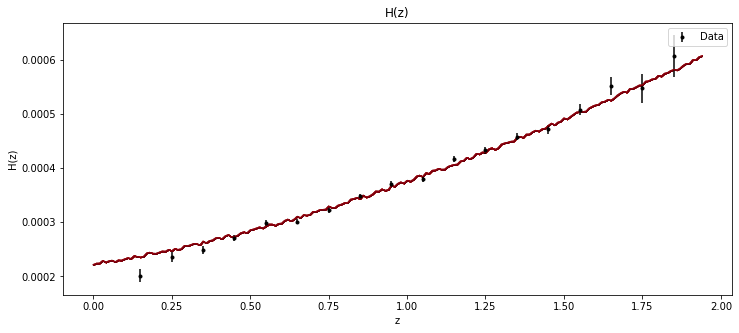

In [9]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["H_gp_f"][0, :, :], z_arr_f[:, None])

# plot the data and the true latent function
#ax.plot(z_arr_f[:, None], H_arr_f, "dodgerblue", lw=3, label=r'$LCDM$')
ax.errorbar(z_arr[:, None], H_data, yerr=sig_H_arr, fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("z")
plt.ylabel("H(z)")
plt.title("H(z)")
plt.legend();

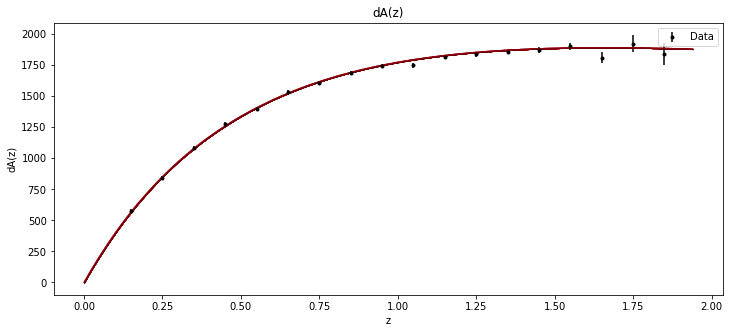

In [10]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["dA_gp_f"][0, :, :], z_arr_f[:, None])

# plot the data and the true latent function
#ax.plot(z_arr_f[:, None], dA_arr_f, "dodgerblue", lw=3, label=r'$LCDM$')
ax.errorbar(z_arr[:, None], dA_data, yerr=sig_dA_arr, fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("z")
plt.ylabel("dA(z)")
plt.title("dA(z)")
plt.legend();

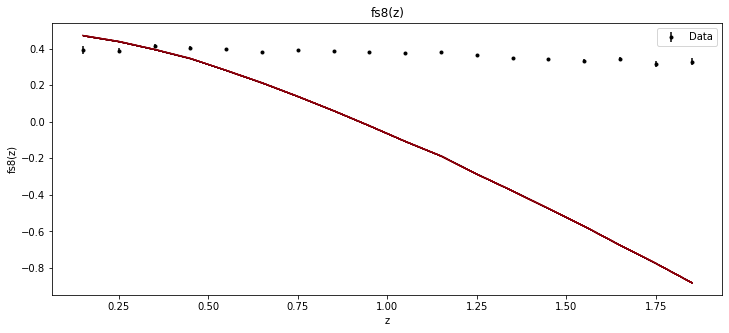

In [11]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["fs8_gp"][0, :, :], z_arr[:, None])

# plot the data and the true latent function
#ax.plot(z_arr[:, None], fs_model, "dodgerblue", lw=3, label=r'$LCDM$')
ax.errorbar(z_arr[:, None], fs_data, yerr=sig_fs_arr, fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("z")
plt.ylabel("fs8(z)")
plt.title("fs8(z)")
plt.legend();

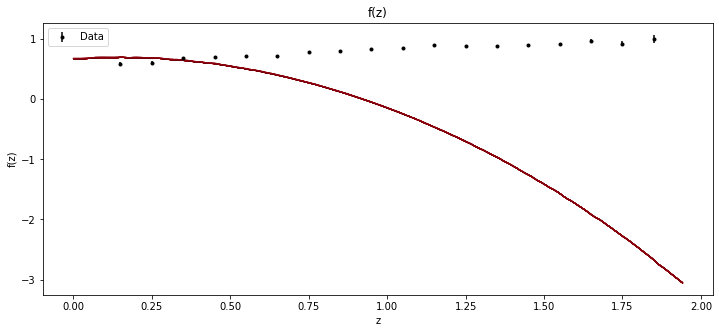

In [12]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, (trace.posterior["fs8_gp_f"]/s8_arr_f)[0, :, :], z_arr_f[:, None])

# plot the data and the true latent function
#ax.plot(z_arr[:, None], fs_model/s8_arr_f[idx], "dodgerblue", lw=3, label=r'$LCDM$')
ax.errorbar(z_arr[:, None], fs_data/s8_arr_f[idx], yerr=sig_fs_arr/s8_arr_f[idx], fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("z")
plt.ylabel("f(z)")
plt.title("f(z)")
plt.legend();

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["fs_f"][0, :, :], z_arr_f[:, None])

# plot the data and the true latent function
ax.plot(z_arr[:, None], fs_model, "dodgerblue", lw=3, label=r'$LCDM$')
ax.errorbar(z_arr[:, None], fs_data, yerr=sig_fs_arr, fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("z")
plt.ylabel("fs8(z)")
plt.title("fs8(z)")
plt.legend();

In [ ]:
#z_new
# add the GP conditional to the model, given the new X values
z_new = np.arange(0., 3+0.1, 0.01)[:, None]
with model:
    DHkms_pred = gp.conditional("DHkms_pred", z_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace.posterior, samples=1000, var_names=["DHkms_pred"])

In [ ]:
import pickle
with open(os.path.join(path, 'prediction.pkl'), 'wb') as buff:
    pickle.dump({'pred_samples': pred_samples,
                 'z_new': z_new}, buff)
with open(os.path.join(path, 'trace.pkl'), 'wb') as buff:
        pickle.dump({'trace': trace}, buff)    

In [ ]:
# plot the results
fig = plt.figure()
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples["DHkms_pred"]+Hkms_new, z_new)
# plot the data and the true latent function
plt.plot(z_new, Hkms_new, "dodgerblue", lw=2, label="LCDM")
ax.errorbar(z_arr[:, None], Hkms_data , yerr=sig_Hkms_arr, fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("z")
plt.ylabel(r'$he5$')
#plt.ylim([-1.3, 4])
#plt.xlim([0, 3])
plt.legend();